In [1]:
import sys

sys.path.append('../../')

import numpy as np
import random
import pylab as plt
from matplotlib.lines import Line2D
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

from bayes_opt import BayesianOptimization

from sklearn import datasets
from dal_toolbox.models.resnet import train_one_epoch, evaluate
from dal_toolbox.models.ssl_train_methods.pimodel import train_one_epoch as pi_train_one_epoch
from dal_toolbox.models.ssl_train_methods.pseudolabel import train_one_epoch as pseudo_train_one_epoch

In [2]:
# A key aspect for semi supervised learning is data augmentation. We therefore need a Custom Dataset that
# applys these random augmentations to the samples. For torchvision datasets usually transforms is used.

class GaussianNoiseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y, mean=0, std=1, p_noise=0.85):
        super(GaussianNoiseDataset, self).__init__(X, y)
        self.mean = mean
        self.std = std
        self.p_noise = p_noise
        assert p_noise > 0 and p_noise <= 1, "p_noise is a probability and should be between 0 and 1"

    def __getitem__(self, idx):
        X, y = super().__getitem__(idx)
        if torch.randn((1)) < self.p_noise:
            return (X + torch.randn(X.shape) * self.std + self.mean, y)
        else:
            return (X, y)

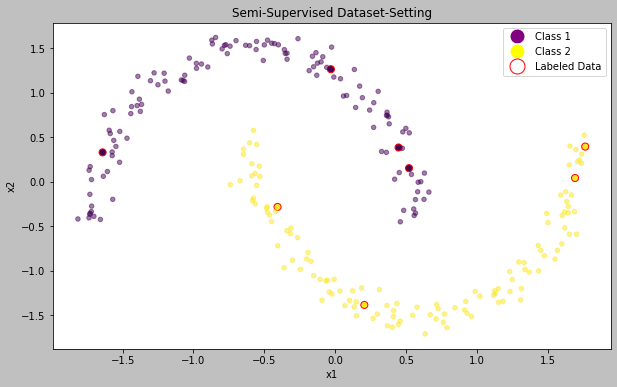

In [3]:
# Creating a simple dataset two_moons from sklearn with some noise

X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

random.seed(2)

labeled_idx = random.sample([i for i in range(len(y)) if y[i] == 0], k=4) + random.sample([i for i in range(len(y)) if y[i] == 1], k=4)
unlabeled_idx = [i for i in range(X.shape[0]) if i not in labeled_idx]

X_labeled = X[labeled_idx]
y_labeled = y[labeled_idx]

X_unlabeled = X[unlabeled_idx]
y_unlabeled = y[unlabeled_idx]

lbd_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
val_ds = torch.utils.data.TensorDataset(X, y)
val_loader = DataLoader(val_ds, batch_size=64)
ds = GaussianNoiseDataset(X, y)

plt.figure(figsize=(10,6), facecolor='silver')
plt.title("Semi-Supervised Dataset-Setting")
plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='red')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=20, alpha=0.5)
plt.legend(handles = [
    Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='purple', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Class 2', markerfacecolor='yellow', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Labeled Data', markerfacecolor='white', markeredgecolor='red', markersize=15)
], loc = 'upper right')
plt.show()

In [4]:
# We create a simple model to demonstrate an example. The semi-supervised part will be inside the train-method, 
# so the base model can be varied independently.

class Net(nn.Module):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = 0,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [5]:
# This function plots the decision boundary of a model between class 1 and class 2.
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=20, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=[0, 0.25, 0.5, 0.75, 1], origin=origin)
    CS2 = plt.contour(CS, levels=CS.levels[::2], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [6]:
torch.manual_seed(0)

supervised_optimizer_params = dict(
    lr=0.01,
    weight_decay=0.0001,
    momentum=.9,
)

n_epochs=100

supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
supervised_model = Net(dropout_rate=0, num_classes=2)
supervised_optimizer = torch.optim.SGD(supervised_model.parameters(), **supervised_optimizer_params)
supervised_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(supervised_optimizer, T_max=n_epochs)
criterion = nn.CrossEntropyLoss()

# Supervised model
supervised_history = []
for i in range(n_epochs):
    train_stats = train_one_epoch(supervised_model, supervised_train_loader, criterion, supervised_optimizer, device='cuda', epoch=i)
    supervised_history.append(train_stats)
    supervised_lr_scheduler.step()

Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6993 (0.6993) acc1: 50.0000 (50.0000) time: 0.2997 data: 0.0003 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.009997532801828659 loss: 0.6921 (0.6921) acc1: 50.0000 (50.0000) time: 0.0012 data: 0.0002 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.00999013364214136 loss: 0.6790 (0.6790) acc1: 50.0000 (50.0000) time: 0.0012 data: 0.0002 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.009977809823015401 loss: 0.6620 (0.6620) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0002 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.009960573506572392 loss: 0.6424 (0.6424) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.00993844170297569 loss: 0.6216 (0.6216) acc1: 87.5000 (87.5000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] 

In [14]:
# Pseudolabels Model
torch.manual_seed(0)

pseudo_optimizer_params = dict(
    lr=0.01,
    weight_decay=0.0001,
    momentum=.9,
)

n_epochs=1000

pseudo_model = Net(dropout_rate=0, num_classes=2)
pseudo_optimizer = torch.optim.SGD(pseudo_model.parameters(), **pseudo_optimizer_params)
pseudo_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(pseudo_optimizer, T_max=n_epochs)

supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
unsupervised_loader_1 = DataLoader(ds, batch_size=8, shuffle=True)
pseudo_loaders = {
    "train_sup": supervised_train_loader,
    "train_unsup": unsupervised_loader_1
}

pseudo_history = []
for i in range(n_epochs):
    train_stats = pseudo_train_one_epoch(
        model=pseudo_model, dataloaders=pseudo_loaders, criterion=criterion, 
        optimizer=pseudo_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=2, use_hard_labels=True,
        n_epochs=n_epochs, p_cutoff=0.95)
    pseudo_history.append(train_stats)
    pseudo_lr_scheduler.step()

In [12]:
# Pimodel
torch.manual_seed(0)

pi_optimizer_params = dict(
    lr=0.01,
    weight_decay=0.0001,
    momentum=.9,
)

n_epochs = 1000

pi_model = Net(dropout_rate=0, num_classes=2)
pi_optimizer = torch.optim.SGD(pi_model.parameters(), **pi_optimizer_params)
pi_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(pi_optimizer, T_max=n_epochs)

random_sampler_weak_1 = RandomSampler(ds, generator=torch.Generator().manual_seed(42))
random_sampler_weak_2 = RandomSampler(ds, generator=torch.Generator().manual_seed(42))
supervised_train_loader = DataLoader(lbd_ds, batch_size=8, shuffle=True)
unsupervised_loader_1 = DataLoader(ds, batch_size=8, sampler=random_sampler_weak_1)
unsupervised_loader_2 = DataLoader(ds, batch_size=8, sampler=random_sampler_weak_2)
pi_loaders = {
        "train_sup": supervised_train_loader,
        "train_unsup_weak_1": unsupervised_loader_1,
        "train_unsup_weak_2": unsupervised_loader_2
    }

pi_history = []
for i in range(n_epochs):
    train_stats = pi_train_one_epoch(
        model=pi_model, dataloaders=pi_loaders, criterion=criterion, 
        optimizer=pi_optimizer, device='cuda', epoch=i, unsup_warmup=0.4, lambda_u=4,
        n_epochs=n_epochs)
    pi_history.append(train_stats)
    pi_lr_scheduler.step()

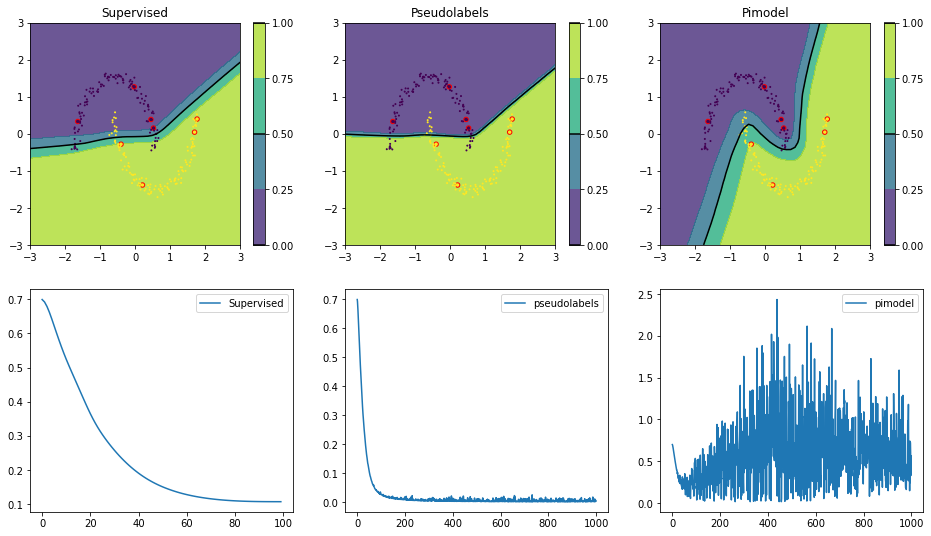

,supervised,pseudolabels,pimodel
test_accuracy,88.400002,88.0,96.800003


In [15]:
# Plot results
supervised_model.eval()
pseudo_model.eval()
pi_model.eval()

fig, axis = plt.subplots(2, 3, figsize=(16,9))
plot_contour(supervised_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][0])
plot_contour(pseudo_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][1])
plot_contour(pi_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled, ax=axis[0][2])
axis[1][0].plot([d[f'train_loss'] for d in supervised_history], label=f'Supervised')
axis[1][1].plot([d[f'train_total_loss'] for d in pseudo_history], label=f'pseudolabels')
axis[1][2].plot([d[f'train_total_loss'] for d in pi_history], label=f'pimodel')

axis[1][0].legend()
axis[1][1].legend()
axis[1][2].legend()

axis[0][0].set_title("Supervised")
axis[0][1].set_title("Pseudolabels")
axis[0][2].set_title("Pimodel")

plt.show()

# Display final accuracys aswell
pd.DataFrame(
    {
        'supervised':{'test_accuracy': evaluate(supervised_model, val_loader, {}, criterion, device='cuda')['test_acc1']},
        'pseudolabels':{'test_accuracy': evaluate(pseudo_model, val_loader, {}, criterion, device='cuda')['test_acc1']},
        'pimodel':{'test_accuracy': evaluate(pi_model, val_loader, {}, criterion, device='cuda')['test_acc1']}
    }
)